In [1044]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  # Import the Support Vector Classifier
import scipy.sparse as sp
import torch.optim as optim
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
%matplotlib inline


# Overview of the initial steps

In the first place, we will import the data from 4 different text files, merge them and then isolate it into three parts. The three parts are the following:

1-Years 2007-2014, this will be the training set

2-Year 2015, this will be the validation set

3-Year 2016, we will test our model with this years data at the end. 

We will further replace the target variable loan status with 1 for Charged Off and with 0 for Fully Paid. 

We will later on try to use the imputer to retain all the data. 

In [1045]:
df1 = pd.read_csv('Lending_Club_modelling_data_part1.txt', delimiter='\t')
df2 = pd.read_csv('Lending_Club_modelling_data_part2.txt', delimiter='\t', dtype={'column_name': str}, low_memory=False)
df3 = pd.read_csv('Lending_Club_modelling_data_part3.txt', delimiter='\t')
df4 = pd.read_csv('Lending_Club_modelling_data_part4.txt', delimiter='\t')

#merged data
df = pd.concat([df1, df2, df3, df4], ignore_index=True)
print("Before dropping na: ",df.shape)

# Drop the title column because it is the same information as purpose
df = df.drop('title', axis=1)

# Fill missing values in 'address' column with the wrong address in mort_acc column
df['address'] = df['address'].fillna( '76093 Nicole Parks\r\nEast Donaldfurt, IN 70466')

# Replace missing values in 'emp_title' column with 'Unknown'
df['emp_title'] = df['emp_title'].fillna('Unknown')

#print rows with missing values, show only if different from 0
print(df.isnull().sum()[df.isnull().sum() > 0])

#replace target variable values with 0 and 1
df['loan_status'] = df['loan_status'].replace({'Charged Off': 1, 'Fully Paid': 0})

# Convert 'issue_d' column to datetime format
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')

# Replace values in 'emp_length' column with numerical values
emp_length_map = {
    '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5,
    '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10
}
df['emp_length'] = df['emp_length'].replace(emp_length_map)

# Correct types of columns
df['revol_util'] = df['revol_util'].replace({'f':'NaN'})
df['revol_util'] = df['revol_util'].astype(float)
df['total_acc'] = df['revol_util'].replace({'INDIVIDUAL':'NaN'})
df['total_acc'] = df['total_acc'].astype(float)
df['mort_acc'] = df['mort_acc'].replace({'76093 Nicole Parks\r\nEast Donaldfurt, IN 70466':'NaN'})
df['mort_acc'] = df['mort_acc'].astype(float)

Before dropping na:  (396030, 25)
emp_length              18301
revol_util                276
mort_acc                37795
pub_rec_bankruptcies      536
dtype: int64


In [1046]:
df['term'] = df['term'].str.replace(' months', '').astype(int)

# small test to see if both profit methods give the same result

In [1047]:
# Display the original and calculated values side by side
result_df = pd.DataFrame({
    'loan_amnt': df['loan_amnt'],
    'term': df['term'],
    'interest': df['int_rate'],
    'installment': df['installment'],
    'interest_calculation': df['loan_amnt'] * (1+df['int_rate'] / 100),
    'term_installment_diff': df['term'] * df['installment'] ,
})

In [1048]:
result_df

,loan_amnt,term,interest,installment,interest_calculation,term_installment_diff
0,10000,36,11.44,329.48,11144.0000,11861.28
1,8000,36,11.99,265.68,8959.2000,9564.48
2,15600,36,10.49,506.97,17236.4400,18250.92
3,7200,36,6.49,220.65,7667.2800,7943.40
4,24375,60,17.27,609.33,28584.5625,36559.80
...,...,...,...,...,...,...
396025,10000,60,10.99,217.38,11099.0000,13042.80
396026,21000,36,12.29,700.42,23580.9000,25215.12
396027,5000,36,9.99,161.32,5499.5000,5807.52
396028,21000,60,15.31,503.02,24215.1000,30181.20


maybe yearly interest??

In [1049]:
year1=11144.0000-12*329.48 #first interest - first year payments=remaning amount of debt after the first year
year2=year1*(1+11.44/100)-12*329.48 #remaining amount of debt after the second year
year3=year2*(1+11.44/100)-12*329.48 #remaining amount of debt after the third year (has to be 0 but not)
year3

569.6380273664008

# Net Profit Function (original)

In [1050]:
# Define the net_profit function 
def net_profit(y_pred, df):
    # Extract relevant columns from DataFrame as NumPy arrays
    loan_amnt = df['loan_amnt'].values
    int_rate = df['int_rate'].values
    loan_status = df['loan_status'].values
    
    # Who received loans with the model
    index = (y_pred == 0)
    # Who paid back the loans
    index_payback = (loan_status == 0)
    # Who defaulted on the loans
    index_default = (loan_status == 1)
    
    # Calculate profit for loans that were paid back
    paid_back_loans = index & index_payback
    profit_paid_back = loan_amnt[paid_back_loans] * (int_rate[paid_back_loans] / 100)
    total_profit = np.sum(profit_paid_back)
    
    # Calculate loss for loans that defaulted
    defaulted_loans = index & index_default
    loss_defaulted = loan_amnt[defaulted_loans] * 0.5
    total_loss = np.sum(loss_defaulted)
    
    return total_profit - total_loss
    #return total_profit,total_loss,total_profit - total_loss

# Net Profit Function 2 (updated)

In [1051]:
# Define the net_profit function 
def net_profit2(y_pred, df):
    # Extract relevant columns from DataFrame as NumPy arrays
    loan_amnt = df['loan_amnt'].values
    installment = df['installment'].values
    term = df['term'].replace({-1: 36, 1: 60}).values
    loan_status = df['loan_status'].values
    
    # Who received loans with the model
    index = (y_pred == 0)
    # Who paid back the loans
    index_payback = (loan_status == 0)
    # Who defaulted on the loans
    index_default = (loan_status == 1)
    
    # Calculate profit for loans that were paid back
    paid_back_loans = index & index_payback
    profit_paid_back = installment[paid_back_loans]*term[paid_back_loans]-loan_amnt[paid_back_loans]
    total_profit = np.sum(profit_paid_back)
    
    # Calculate loss for loans that defaulted
    defaulted_loans = index & index_default
    loss_defaulted = loan_amnt[defaulted_loans] * 0.5 #paid back %50 of the loan before defalting (assumption)
    total_loss = np.sum(loss_defaulted)
    
    return total_profit - total_loss
    #return total_profit,total_loss,total_profit - total_loss

# Preprocessing

In [1052]:
#FOR TERM (36-60 MONTHS) WE ENCODE THEM AS 0-1 AND INCLUDE THEM IN THE NUMERICAL COLUMNS
#df['term'] = df['term'].str.replace(' months', '').astype(int)
df['term'] = df['term'].replace({ 36: -1, 60: 1})

#For verification status we use one hot encoding
df = pd.get_dummies(df, columns=['verification_status'], sparse=True)
df['verification_status_Not Verified'] = df['verification_status_Not Verified'].astype(int)
#df['verification_status_Source Verified'] = df['verification_status_Source Verified'].astype(int) 
df['verification_status_Verified'] = df['verification_status_Verified'].astype(int)
df.drop('verification_status_Source Verified', axis=1, inplace=True) #drop this column as it is redundant (control)

#For home ownership we use one hot encoding
df = pd.get_dummies(df, columns=['home_ownership'], sparse=True)
df['home_ownership_MORTGAGE'] = df['home_ownership_MORTGAGE'].astype(int)
df['home_ownership_OWN'] = df['home_ownership_OWN'].astype(int)
df['home_ownership_RENT'] = df['home_ownership_RENT'].astype(int)
df.drop('home_ownership_ANY', axis=1, inplace=True) #drop this column for control
df.drop('home_ownership_NONE', axis=1, inplace=True) #drop this column for control
df.drop('home_ownership_OTHER', axis=1, inplace=True) #drop this column for control

# #for purpose we use one hot encoding
# df = pd.get_dummies(df, columns=['purpose'], sparse=True)
# df['purpose_car'] = df['purpose_car'].astype(int)
# df['purpose_credit_card'] = df['purpose_credit_card'].astype(int)
# df['purpose_debt_consolidation'] = df['purpose_debt_consolidation'].astype(int)
# df['purpose_educational'] = df['purpose_educational'].astype(int)
# df['purpose_home_improvement'] = df['purpose_home_improvement'].astype(int)
# df['purpose_house'] = df['purpose_house'].astype(int)
# df['purpose_major_purchase'] = df['purpose_major_purchase'].astype(int)
# df['purpose_medical'] = df['purpose_medical'].astype(int)
# df['purpose_moving'] = df['purpose_moving'].astype(int)
# df['purpose_renewable_energy'] = df['purpose_renewable_energy'].astype(int)
# df['purpose_small_business'] = df['purpose_small_business'].astype(int)
# df['purpose_vacation'] = df['purpose_vacation'].astype(int)
# df['purpose_wedding'] = df['purpose_wedding'].astype(int)
# df.drop('purpose_other', axis=1, inplace=True) #drop this column for control


#remove rows with pub_rec_bankruptcies > 5
#df = df[df['pub_rec_bankruptcies'] <= 5]

#remove rows with pub_rec > 10
#df = df[df['pub_rec'] <= 10]

#remove rows with annual income > 300000
#df = df[df['annual_inc'] <= 300000]

# Convert 'issue_d' column to datetime format
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')


# -----------------------------------------------------

# Feature Engineering 

Define monthly income/installement ratio as feature and drop annnal income, installment, loan amount, interest rate as all these information is coded in the ratio.

# Implementation

this is step is important for profit calculation provided that the feature engineering is implemented. 

In [1053]:
df_original=df.copy()
# Separate the data into three groups based on the year ranges
original_training_set = df_original[df_original['issue_d'].dt.year < 2015]
original_validation_set = df_original[df_original['issue_d'].dt.year == 2015]
original_test_set = df_original[df_original['issue_d'].dt.year == 2016]

# Optionally, you may want to reset the index for each subset
original_training_set.reset_index(drop=True, inplace=True)
original_validation_set.reset_index(drop=True, inplace=True)
original_test_set.reset_index(drop=True, inplace=True)
    

uncomment if you would like to use the feature enginneering. 

In [1054]:
# #df['annual_inc']=df['annual_inc']/12 #convert annual income to monthly income
# df['installment_over_income'] = df['installment'] / df['annual_inc'] / 12
# df['installment_over_income'] = df['installment_over_income'].replace([np.inf, -np.inf], np.nan)
# df.drop('installment', axis=1, inplace=True) #drop this column as it is redundant
# df.drop('int_rate', axis=1, inplace=True) #redundant
# df.drop('loan_amnt', axis=1, inplace=True)

# df.drop('annual_inc', axis=1, inplace=True) #drop this column as it is redundant



# -----------------------------------------------------

In [1055]:
# Separate the data into three groups based on the year ranges
training_set = df[df['issue_d'].dt.year < 2015]
validation_set = df[df['issue_d'].dt.year == 2015]
test_set = df[df['issue_d'].dt.year == 2016]

# Optionally, you may want to reset the index for each subset
training_set.reset_index(drop=True, inplace=True)
validation_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)

# Print the number of rows in each group
print("Number of rows in training set:", len(training_set))
print("Number of rows in validation set:", len(validation_set))
print("Number of rows in test set:", len(test_set))

Number of rows in training set: 273678
Number of rows in validation set: 94264
Number of rows in test set: 28088


# Next Steps

Now we would like to get the numerical columns, impute them, normalize the data and apply feature selection.

Then we use SMOTE to oversample the data to overcome the problems arising from the inbalanced nature of the data set. We also try weighted regression. Afterwards we can compare results. One clear advantege of weighted regression is that one can manually arrange the weights thus if the management wants to prioritize giving loans the weight can be decreased and can be increased otherwise. Higher weights lead to stricter decisions which result in less given loans overall. 

Then we fit the data and come up with our predictions using logistic regression. 


In [1056]:
categorical_columns = df.select_dtypes(include='object').columns.tolist()
print("\nCategorical Columns:")
print(categorical_columns)

numerical_columns = df.select_dtypes(include='number').columns.tolist()
print("\nNumerical Columns:")
print(numerical_columns)


Categorical Columns:
['emp_title', 'purpose', 'earliest_cr_line', 'initial_list_status', 'application_type', 'address']

Numerical Columns:
['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'loan_status', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'verification_status_Not Verified', 'verification_status_Verified', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT']


In [1057]:
num_training_set = training_set[numerical_columns].drop('loan_status', axis=1)
numerical_columns_without_loan_status= num_training_set.columns
imputer = IterativeImputer(random_state=0)
imputer.fit(num_training_set)

imputed_array = imputer.transform(num_training_set[numerical_columns_without_loan_status])
num_training_set = pd.DataFrame(imputed_array, columns=numerical_columns_without_loan_status)

# Concatenate imputed features with target variable
training_set[numerical_columns_without_loan_status] = num_training_set

# Check for missing values in the training set
print("Missing values in the training set:")
print(training_set.isnull().sum()[training_set.isnull().sum() > 0])

Missing values in the training set:
Series([], dtype: int64)


/var/folders/l6/8b55cv6j40b20nltsdxdq57h0000gn/T/ipykernel_72497/1054685528.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set[numerical_columns_without_loan_status] = num_training_set


In [1058]:
X_train,y_train = training_set[numerical_columns].drop('loan_status', axis=1), training_set['loan_status']

# Get column names before scaling
feature_names = X_train.columns.tolist()

# Initialize scalers
robust_scaler = RobustScaler()
scaler = sklearn.preprocessing.StandardScaler()

# Fit and transform the numerical features
X_train_scaled = robust_scaler.fit_transform(X_train)
#X= scaler.fit_transform(X)

# Apply SMOTE only to the training data
smote = SMOTE( sampling_strategy=0.8,random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Initialize logistic regression model
model = LogisticRegression(penalty='l2', C=1 , solver='lbfgs', random_state=42)
#model = LogisticRegression()

# Initialize RFE
rfe = RFE(model, n_features_to_select=10)  # Select top 10 features

# Fit RFE
rfe.fit(X_train_resampled, y_train_resampled)

# print the selected features
selected_feature_indices = np.where(rfe.support_)[0]
selected_features = [ feature_names[i] for i in selected_feature_indices]
print("Selected Features:", selected_features)

# Get selected features
X_resampled_rfe = X_train_resampled[:, rfe.support_]

model.fit(X_resampled_rfe, y_train_resampled)
y_train_pred = model.predict(X_train_scaled[:, rfe.support_])
y_prob = model.predict_proba(X_train_scaled[:, rfe.support_])
y_prob_positive_class = y_prob[:,0]

# Evaluate the model
accuracy = accuracy_score(y_train, y_train_pred)
print("TRAINING SET")
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

true_positives = np.sum((y_train == 1) & (y_train_pred == 1))
false_positives = np.sum((y_train == 0) & (y_train_pred == 1)) 
false_negatives = np.sum((y_train == 1) & (y_train_pred == 0))
true_negatives = np.sum((y_train == 0) & (y_train_pred == 0))   

true_negative_rate = true_negatives / (true_negatives + false_positives)
true_positive_rate = true_positives / (true_positives + false_negatives)
print("True Negative Rate (non default as non default):", true_negative_rate)
print("True Positive Rate (default as default):", true_positive_rate)

Selected Features: ['term', 'int_rate', 'annual_inc', 'dti', 'mort_acc', 'verification_status_Not Verified', 'verification_status_Verified', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT']
TRAINING SET
Accuracy: 0.7133419566059384
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.76      0.81    223166
           1       0.32      0.51      0.40     50512

    accuracy                           0.71    273678
   macro avg       0.60      0.64      0.60    273678
weighted avg       0.77      0.71      0.74    273678

True Negative Rate (non default as non default): 0.759049317548372
True Positive Rate (default as default): 0.511403230915426


Profit improvement in the training set:

In [1059]:
# net profit of the model
net_train_profit_model=net_profit(y_train_pred,original_training_set)
#print("Net profit:", net_train_profit_model)

# Create vector of 0s (i.e. everyone receievd the loan in the training set) of size equal to the number of rows in the training set 
zeros=np.zeros(len(training_set))
net_train_profit=net_profit(zeros,original_training_set)
#print("Net profit original:", net_train_profit)

improved_profit=net_train_profit_model-net_train_profit
print("Improved profit:", improved_profit)
#print(net_train_profit_model)
#print(net_train_profit)

Improved profit: 62953930.45999998


In [1060]:
# net profit of the model
net_train_profit_model=net_profit2(y_train_pred,original_training_set)
#print("Net profit:", net_train_profit_model)

# Create vector of 0s (i.e. everyone receievd the loan in the training set) of size equal to the number of rows in the training set 
zeros=np.zeros(len(training_set))
net_train_profit=net_profit2(zeros,original_training_set)
#print("Net profit original:", net_train_profit)

#print(net_train_profit_model)
#print(net_train_profit)
improved_profit=net_train_profit_model-net_train_profit
print("Improved profit:", improved_profit)

Improved profit: -168335624.45999992


See the weights assigned to features with the logistic regression to see which feature was deemed to be of higher importance. 

In [1061]:
# Get the feature weights (coefficients)
feature_weights = model.coef_[0]

# Create a DataFrame to display feature names and their weights
weights_df = pd.DataFrame({'Feature': X_train[selected_features].columns, 'Weight': feature_weights})

# Sort the DataFrame by absolute weight value (for easier interpretation)
weights_df['Weight_Abs'] = weights_df['Weight'].abs()  # Add column for absolute weight values
weights_df = weights_df.sort_values(by='Weight_Abs', ascending=False).drop('Weight_Abs', axis=1)

print(weights_df)


                            Feature    Weight
1                          int_rate  0.653640
0                              term  0.276437
3                               dti  0.256273
5  verification_status_Not Verified -0.216561
2                        annual_inc -0.165708
6      verification_status_Verified -0.142173
4                          mort_acc -0.139367
9               home_ownership_RENT  0.059573
7           home_ownership_MORTGAGE -0.042507
8                home_ownership_OWN -0.010140


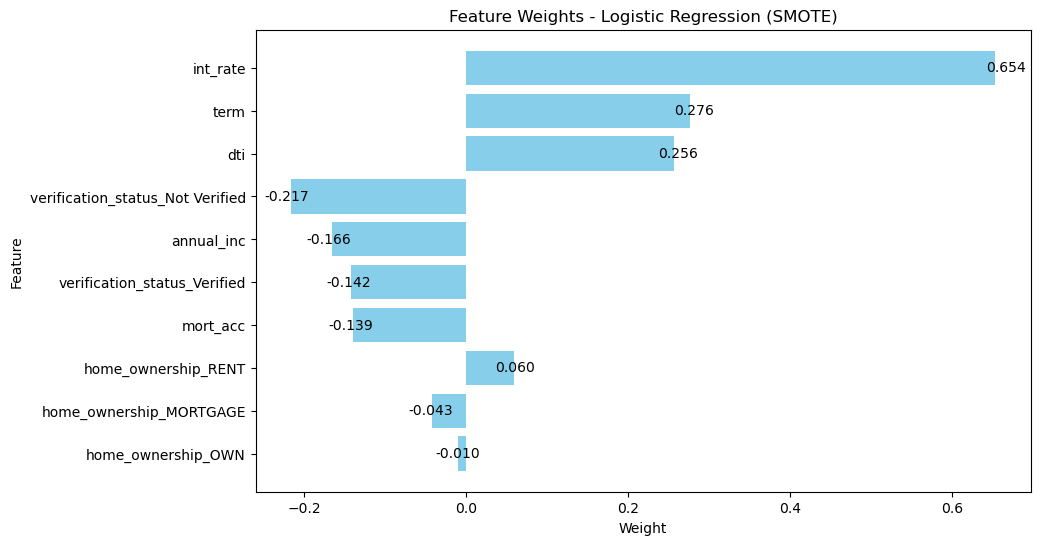

In [1062]:
# Plotting the feature weights
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
bars = plt.barh(weights_df['Feature'], weights_df['Weight'], color='skyblue')
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('Feature Weights - Logistic Regression (SMOTE)')

# Invert y-axis to display most important features at the top
plt.gca().invert_yaxis()

# Add value labels on top of each bar
for bar in bars:
    plt.text(bar.get_width() * 1.02, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.3f}', 
             ha='center', va='center', color='black', fontsize=10)

plt.show()

Now we test the model on the validation set.

We see that the false positive rate is slightly better than the one of the training set. This shows that the model can be generalized.  

In [1063]:
num_validation_set = validation_set[numerical_columns].drop('loan_status', axis=1)
numerical_columns_without_loan_status= num_validation_set.columns

imputed_array = imputer.transform(num_validation_set[numerical_columns_without_loan_status])
num_validation_set = pd.DataFrame(imputed_array, columns=numerical_columns_without_loan_status)

# Concatenate imputed features with target variable
validation_set[numerical_columns_without_loan_status] = num_validation_set

# Check for missing values in the training set
print("Missing values in the training set:")
print(validation_set.isnull().sum()[validation_set.isnull().sum() > 0])

Missing values in the training set:
Series([], dtype: int64)


/var/folders/l6/8b55cv6j40b20nltsdxdq57h0000gn/T/ipykernel_72497/748049171.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_set[numerical_columns_without_loan_status] = num_validation_set


In [1064]:
numerical_columns = validation_set.select_dtypes(include='number').columns.tolist()
numerical_validation_set = validation_set[numerical_columns].copy()
numerical_validation_set_relevant_features = numerical_validation_set[selected_features]

X,y = numerical_validation_set_relevant_features, validation_set['loan_status']
X = robust_scaler.fit_transform(X)

y_pred = model.predict(X)
y_prob = model.predict_proba(X)
y_prob_positive_class = y_prob[:,1]

# Evaluate the model
accuracy = accuracy_score(y, y_pred)
print("VALIDATION SET")
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y, y_pred))

# #check if probability versus attribution works as expected
# print("y_prob_positive_class:", y_prob_positive_class)
# print(y_pred)

true_positives = np.sum((y == 1) & (y_pred == 1))
false_positives = np.sum((y == 0) & (y_pred == 1)) 
false_negatives = np.sum((y == 1) & (y_pred == 0))
true_negatives = np.sum((y == 0) & (y_pred == 0))   

true_negative_rate = true_negatives / (true_negatives + false_positives)
true_positive_rate = true_positives / (true_positives + false_negatives)
print("True Negative Rate (non default as non default):", true_negative_rate)
print("True Positive Rate (default as default):", true_positive_rate)


VALIDATION SET
Accuracy: 0.71763345497751
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81     70791
           1       0.44      0.47      0.45     23473

    accuracy                           0.72     94264
   macro avg       0.63      0.64      0.63     94264
weighted avg       0.72      0.72      0.72     94264

True Negative Rate (non default as non default): 0.7992965207441624
True Positive Rate (default as default): 0.471350061773101


Profit impovement in the validation set

In [1065]:
# net profit of the model
net_val_profit_model=net_profit(y_pred,original_validation_set)
print("Net profit:", net_val_profit_model)

# Create vector of 0s (i.e. everyone receievd the loan in the training set) of size equal to the number of rows in the training set 
zeros=np.zeros(len(y_pred))
net_val_profit=net_profit(zeros,original_validation_set)
print("Net profit original:", net_val_profit)

improved_profit=net_val_profit_model-net_val_profit
print("Improved profit:", improved_profit)

Net profit: -861672.9474999905
Net profit original: -48272015.629999995
Improved profit: 47410342.682500005


ROC curve and AUC score

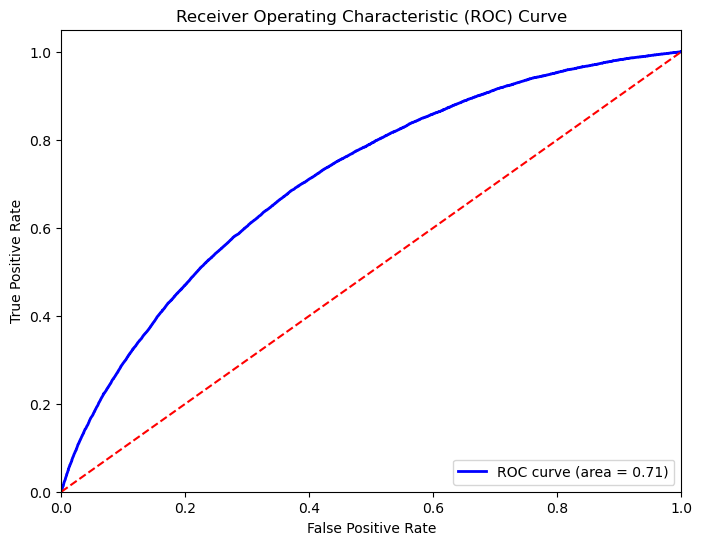

AUC Score: 0.7114489454104503


In [1066]:
accuracy = accuracy_score(y, y_pred)
classification_rep = classification_report(y, y_pred)

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y, y_prob_positive_class)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
print("AUC Score:", roc_auc)

# TEST SET


In [1067]:
numerical_columns = test_set.select_dtypes(include='number').columns.tolist()
numerical_test_set = test_set[numerical_columns].copy()
numerical_test_set_relevant_features = numerical_test_set[selected_features]

X,y = numerical_test_set_relevant_features, test_set['loan_status']
X = robust_scaler.fit_transform(X)

y_pred = model.predict(X)
y_prob = model.predict_proba(X)
y_prob_positive_class = y_prob[:,1]

# Evaluate the model
accuracy = accuracy_score(y, y_pred)
print("TEST SET")
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y, y_pred))

true_positives = np.sum((y == 1) & (y_pred == 1))
false_positives = np.sum((y == 0) & (y_pred == 1)) 
false_negatives = np.sum((y == 1) & (y_pred == 0))
true_negatives = np.sum((y == 0) & (y_pred == 0))   

true_negative_rate = true_negatives / (true_negatives + false_positives)
true_positive_rate = true_positives / (true_positives + false_negatives)
print("True Negative Rate (non default as non default):", true_negative_rate)
print("True Positive Rate (default as default):", true_positive_rate)

TEST SET
Accuracy: 0.7243306750213614
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.76      0.83     24400
           1       0.24      0.50      0.32      3688

    accuracy                           0.72     28088
   macro avg       0.57      0.63      0.57     28088
weighted avg       0.82      0.72      0.76     28088

True Negative Rate (non default as non default): 0.7582377049180328
True Positive Rate (default as default): 0.5


# Weighted regression

The second model we try here is the weighted logistic regression. Since both of these models are quite similar i keep this model in the same file.

In [1068]:
numerical_columns = training_set.select_dtypes(include='number').columns.tolist()
numerical_training_set = training_set[selected_features].copy()
#numerical_training_set.dropna(axis=1, inplace=True)
numerical_training_set 
X,y = numerical_training_set, training_set['loan_status']

# Get column names before scaling
feature_names = X.columns.tolist()

# Initialize scalers
robust_scaler = RobustScaler()
scaler = sklearn.preprocessing.StandardScaler()

# Fit and transform the numerical features
X_scaled = robust_scaler.fit_transform(X)

# Fit a weighted logistic regression model
weights = {0: 1, 1: 5} # Weight 4 for class 1 (minority class)
weighted_lr_model = LogisticRegression(random_state=42, class_weight=weights)
weighted_lr_model.fit(X_scaled, y)
 
# Make predictions with the weighted model
y_pred_weighted_lr = weighted_lr_model.predict(X_scaled)

# Evaluate the model
print("training set")
accuracy = accuracy_score(y, y_pred_weighted_lr)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y, y_pred_weighted_lr))
# #confusion matrix
# cm = sklearn.metrics.confusion_matrix(y, y_pred_weighted_lr)
# print(cm)
true_positives = np.sum((y == 1) & (y_pred_weighted_lr == 1))
false_positives = np.sum((y == 0) & (y_pred_weighted_lr == 1)) 
false_negatives = np.sum((y == 1) & (y_pred_weighted_lr == 0))
true_negatives = np.sum((y == 0) & (y_pred_weighted_lr == 0))   

true_negative_rate = true_negatives / (true_negatives + false_positives)
true_positive_rate = true_positives / (true_positives + false_negatives)
print("True Negative Rate (non default as non default):", true_negative_rate)
print("True Positive Rate (default as default):", true_positive_rate)

training set
Accuracy: 0.6157126257865082
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.60      0.72    223166
           1       0.28      0.69      0.40     50512

    accuracy                           0.62    273678
   macro avg       0.59      0.64      0.56    273678
weighted avg       0.78      0.62      0.66    273678

True Negative Rate (non default as non default): 0.59933412795856
True Positive Rate (default as default): 0.6880741210009502


Profit impovement in the training set

In [1069]:
# net profit of the model
net_train_profit_model_weigted=net_profit(y_pred_weighted_lr,original_training_set)
print("Net profit:", net_train_profit_model_weigted)

# Create vector of 0s (i.e. everyone receievd the loan in the training set) of size equal to the number of rows in the training set 
zeros=np.zeros(len(training_set))
net_train_profit=net_profit(zeros,original_training_set)
print("Net profit original:", net_train_profit)

improved_profit=net_train_profit_model_weigted-net_train_profit
print("Improved profit:", improved_profit)

Net profit: 86886856.35749999
Net profit original: 33980007.84500003
Improved profit: 52906848.51249996


See the weights assigned to features with the logistic regression to see which feature was deemed to be of higher importance. 

In [1070]:
# Get the feature weights (coefficients)
feature_weights = weighted_lr_model.coef_[0]
# Create a DataFrame to display feature names and their weights
weights_df = pd.DataFrame({'Feature': X[selected_features].columns, 'Weight': feature_weights})

# Sort the DataFrame by absolute weight value (for easier interpretation)
weights_df['Weight_Abs'] = weights_df['Weight'].abs()  # Add column for absolute weight values
weights_df = weights_df.sort_values(by='Weight_Abs', ascending=False).drop('Weight_Abs', axis=1)

print(weights_df)


                            Feature    Weight
1                          int_rate  0.643114
0                              term  0.284969
3                               dti  0.254560
5  verification_status_Not Verified -0.195623
6      verification_status_Verified -0.144385
2                        annual_inc -0.138134
4                          mort_acc -0.094045
7           home_ownership_MORTGAGE -0.087034
9               home_ownership_RENT  0.069356
8                home_ownership_OWN  0.015495


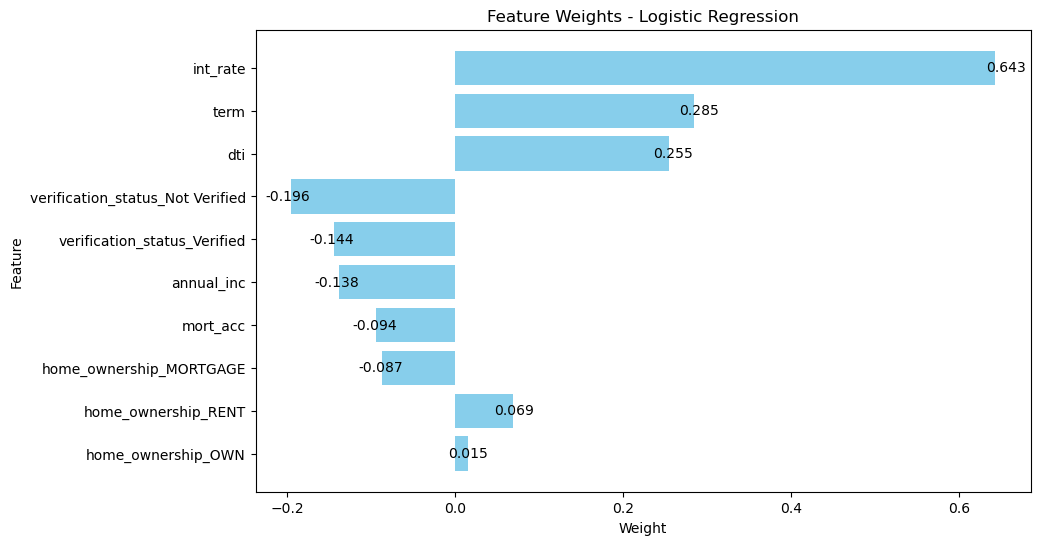

In [1071]:
# Plotting the feature weights
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
bars = plt.barh(weights_df['Feature'], weights_df['Weight'], color='skyblue')
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('Feature Weights - Logistic Regression')

# Invert y-axis to display most important features at the top
plt.gca().invert_yaxis()

# Add value labels on top of each bar
for bar in bars:
    plt.text(bar.get_width() * 1.02, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.3f}', 
             ha='center', va='center', color='black', fontsize=10)

plt.show()

Test the model on the validation set. We set that the results are similar which implies that the method can be generalized. 

In [1072]:
numerical_columns = validation_set.select_dtypes(include='number').columns.tolist()
numerical_validation_set = validation_set[numerical_columns].copy()
#numerical_validation_set.dropna(axis=1, inplace=True)
#doesnt exist in the training set
#numerical_validation_set=numerical_validation_set.drop('pub_rec_bankruptcies', axis=1)
#imputed_array = imputer.transform(numerical_validation_set[numerical_columns_without_loan_status])
numerical_validation_set = pd.DataFrame(imputed_array, columns=numerical_columns_without_loan_status)

numerical_validation_set_relevant_features = numerical_validation_set[selected_features]


X,y_val = numerical_validation_set_relevant_features, validation_set['loan_status']
X = robust_scaler.fit_transform(X)

y_pred_weighted_lr_val = weighted_lr_model.predict(X)
y_prob = weighted_lr_model.predict_proba(X)
y_prob_positive_class_lr = y_prob[:,1]

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred_weighted_lr_val)
print("VALIDATION SET")
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_val, y_pred_weighted_lr_val))


true_positives = np.sum((y_val == 1) & (y_pred_weighted_lr_val == 1))
false_positives = np.sum((y_val == 0) & (y_pred_weighted_lr_val == 1)) 
false_negatives = np.sum((y_val == 1) & (y_pred_weighted_lr_val == 0))
true_negatives = np.sum((y_val == 0) & (y_pred_weighted_lr_val == 0))   

true_negative_rate = true_negatives / (true_negatives + false_positives)
true_positive_rate = true_positives / (true_positives + false_negatives)
print("True Negative Rate (non default as non default):", true_negative_rate)
print("True Positive Rate (default as default):", true_positive_rate)


VALIDATION SET
Accuracy: 0.6557858779597725
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.66      0.74     70791
           1       0.39      0.66      0.49     23473

    accuracy                           0.66     94264
   macro avg       0.62      0.66      0.61     94264
weighted avg       0.74      0.66      0.68     94264

True Negative Rate (non default as non default): 0.6560297212922547
True Positive Rate (default as default): 0.6550504835342734


Profit improvement in the validation set

In [1073]:
# net profit of the model
net_val_profit_model_weigted=net_profit(y_pred_weighted_lr_val,original_validation_set)
print("Net profit:", net_val_profit_model_weigted)

# Create vector of 0s (i.e. everyone receievd the loan in the training set) of size equal to the number of rows in the training set 
zeros=np.zeros(len(validation_set))
net_val_profit=net_profit(zeros,original_validation_set)
print("Net profit original:", net_val_profit)

improved_profit=net_val_profit_model_weigted-net_val_profit
print("Improved profit:", improved_profit)

Net profit: 9212262.737499997
Net profit original: -48272015.629999995
Improved profit: 57484278.36749999


In [1074]:
accuracy = accuracy_score(y, y_pred_weighted_lr_val)
classification_rep = classification_report(y, y_pred_weighted_lr_val)

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y, y_prob_positive_class_lr)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
print("AUC Score:", roc_auc)

ValueError: Found input variables with inconsistent numbers of samples: [273678, 94264]

In [ ]:
numerical_columns = test_set.select_dtypes(include='number').columns.tolist()
numerical_test_set = test_set[numerical_columns].copy()
#numerical_test_set.dropna(axis=1, inplace=True)
#doesnt exist in the training set
#numerical_test_set=numerical_test_set.drop('pub_rec_bankruptcies', axis=1)
imputed_array = imputer.transform(numerical_test_set[numerical_columns_without_loan_status])
numerical_test_set = pd.DataFrame(imputed_array, columns=numerical_columns_without_loan_status)

numerical_test_set_relevant_features = numerical_test_set[selected_features]

X_test,y_test = numerical_test_set_relevant_features, test_set['loan_status']
X_test = robust_scaler.fit_transform(X_test)

y_pred_weighted_lr_test = weighted_lr_model.predict(X_test)
y_prob = weighted_lr_model.predict_proba(X_test)
y_prob_positive_class_lr = y_prob[:,1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_weighted_lr_test)
print("TEST SET")
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred_weighted_lr_test))


true_positives = np.sum((y_test == 1) & (y_pred_weighted_lr_test == 1))
false_positives = np.sum((y_test == 0) & (y_pred_weighted_lr_test == 1)) 
false_negatives = np.sum((y_test == 1) & (y_pred_weighted_lr_test == 0))
true_negatives = np.sum((y_test == 0) & (y_pred_weighted_lr_test == 0))   

true_negative_rate = true_negatives / (true_negatives + false_positives)
true_positive_rate = true_positives / (true_positives + false_negatives)
print("True Negative Rate (non default as non default):", true_negative_rate)
print("True Positive Rate (default as default):", true_positive_rate)

# #check if probability versus attribution works as expected
# print("y_prob_positive_class:", y_prob_positive_class)
# print(y_pred_weighted_lr)

TEST SET
Accuracy: 0.6894047279977215
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80     24400
           1       0.23      0.56      0.32      3688

    accuracy                           0.69     28088
   macro avg       0.57      0.63      0.56     28088
weighted avg       0.82      0.69      0.74     28088

True Negative Rate (non default as non default): 0.708811475409836
True Positive Rate (default as default): 0.5610086767895879


profit in the test set

In [ ]:
# net profit of the model
net_test_profit_model_weigted=net_profit(y_pred_weighted_lr_test,original_test_set)
print("Net profit:", net_test_profit_model_weigted)

# Create vector of 0s (i.e. everyone receievd the loan in the training set) of size equal to the number of rows in the training set 
zeros=np.zeros(len(test_set))
net_test_profit=net_profit(zeros,original_test_set)
print("Net profit original:", net_test_profit)

improved_profit=net_test_profit_model_weigted-net_test_profit
print("Improved profit:", improved_profit)

Net profit: 14814563.552500002
Net profit original: 20667631.3575
Improved profit: -5853067.805


----------------------------------------------------------------------------------------------------------------------------------

Thoughts below.

IDEA: try applying wieghted logistic regression with different weights and pick the one that minimizes the false positive rate

IMPORTANCE SAMPLING??

increase the weight of default?? more important in the loss funntion

 OUTLIERS??
 - i take care of this with robust scaling i think

MAYBE CUSTOM LOSS PENALIZING ONLY FALSE POSITIVES?
i could define the loss function as the money loss instead of difference from the actual indices 
then the goal would be to minimize this

XGBOOST?

We obtained a very effective tuning for the classical feedforward network by applying a slight variation of the standard back- propagation algorithm that does not propagate errors if they are below a given threshold. 

NEED TO NORMALIZE FOR NEURAL NETWORKS
- try signatures!